# 22 - Debiased/Orthogonal Machine Learning
 
이 방법은 `meta-learner`라 불리기 전에 인과 추론 분야에 한 획을 한 논문을 통해 발표되었습니다. 논문 제목은 [*Double Machine Learning for Treatment and Causal Parameters* (2016)](https://arxiv.org/abs/1608.00060) 입니다. Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo (Abhijit Banerjee, Michael Kremer와 함께 세계 빈곤 완화에 대한 실험적 접근으로 2020 노벨경제학상 수상), Christian Hansen, Whitney Newey, James Robins 등에 의해 저술되었습니다. 의심할 여지 없이 대단한 논문이기에 저자들을 어벤저스로 표현해 보았습니다. (이는 Paul Goldsmith-Pinkham에 의해 제안되었습니다.)

![img](./data/img/debiased-ml/avengers.png)
 
이 논문의 가장 큰 문제는 계량경제학 논문으로 읽기가 매우 어렵다는 것입니다.😭 이 책의 목적은 인과 추론을 널리 알리는 것이므로 여기서는 Debiased/Orthogonal Machine Learning을 직관적으로 이해해보겠습니다.

다른 meta-learner와 비교해 이 방법이 가진 특별한 장점은 무엇일까요? 제가 관심을 둔 부분은 Debiased/Orthogonal ML의 타당성입니다. 우리가 지금까지 본 다른 방법들 S, T, X-learner는 약간 꼼수처럼 보입니다. 이 방법들이 왜 작동하는지 직관적으로 설명할 수 있었지만, 일반적인 방법으로는 보이지 않습니다. 반면 Debiased/Orthogonal Machine Learning은 매우 직관적이면서도 엄격한 일반 프레임워크 입니다. 추가로 Debiased/Orthogonal ML은 treatment가 연속/이산 변수일 때 모두 적용이 가능한 장점이 있는데, 이는 T, X-learner에서는 할 수 없던 부분입니다. 이를 설명하는 논문들은 놀라운 일들을 해내 왔습니다. 그럼 이제 본론으로 들어가보죠.

다시 한 번 아이스크림 판매 데이터 세트를 사용합니다. 여기서는 가격이 매출에 미치는 영향에 대한 효과를 알고자 합니다. 훈련 데이터는 관측된 가격만 가지고 있어 잠재적으로 편향되어 있지만, 테스트 세트는 가격이 무작위로 할당됩니다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

In [2]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


<AxesSubplot:xlabel='price', ylabel='sales'>

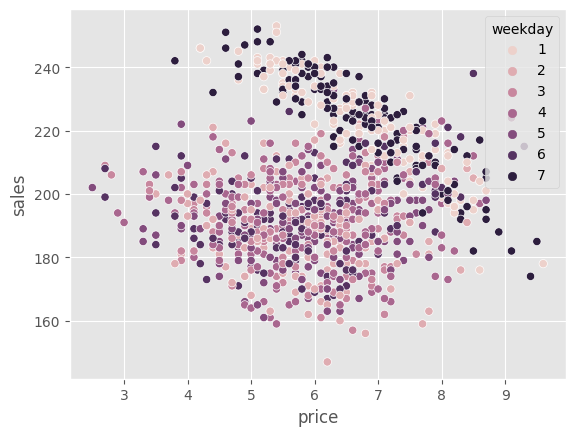

In [3]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

편향의 한 가지 원인은 분명합니다. 위 그래프에 나타난 것처럼 주말(weekday=1,7)에는 가격이 훨씬 높습니다. 반면 온도와 비용과 같은 교란자(cofounder) 또한 존재할 수 있습니다. 따라서 인과 추론을 위해 편향을 보정해야 합니다.

## ML for Nuisance Parameters
 
편향을 제거하기 위한 한 가지 방법은 선형 모델로 교란자를 제어하여 매출에 대한 가격의 treatment 효과를 추정하는 것 입니다.

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 cost_i + \pmb{\beta_3} Weekday_i + e_i
$$
 
$\pmb{\beta_3}$은 weekday와 관련된 파라미터들의 벡터입니다.
 
$\tau$는 treatment 효과를 나타내므로 이 변수에만 관심이 있음에 유의해야 합니다. 다른 파라미터들은 신경 쓰지 않기 때문에 성가신 파라미터라 해봅시다. 하지만 성가신 파라미터는 제대로 처리해야 합니다. 진짜로 신경 쓰지 않는다면 계산된 treatment 효과가 왜곡되기 때문입니다. 이거 짜증 나는군..

예를 들면 온도와 매출과의 관계는 선형이 아닐 수 있습니다. 기온이 올라가면 바닷가에 나가 아이스크림을 사는 사람이 많아지므로 매출이 늘어날 것입니다. 하지만 어느 순간 날씨가 너무 더워지면 사람들은 집에 있는 것을 선호하여 매출은 떨어질 것 입니다. 따라서 매출은 온도에 따라 올라갔다가 내려갈 것으로 예상할 수 있습니다. 이는 선형 모델이 옳지 않다는 의미입니다. 아래와 같이 이차항이 필요합니다.
 
$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 temp^2_i + \beta_3 cost_i + \pmb{\beta_4} Weekday_i + e_i
$$
 
![img](./data/img/debiased-ml/non-linear.png)

성가신 변수 처리를 고민하는 것은 몇 가지 공변량 만으로도 벌써 지루합니다. 만약 수백 개라면? 많은 데이터 세트에서 매우 흔한 일입니다. 어쩌죠? 답은 역사적으로 가장 멋진 계량경제학 이론에 있습니다.

### Frisch-Waugh-Lovell
 
Frisch, Waugh, Lovell은 선형 회귀의 멋진 특징을 알아낸 20세기 계량경제학자입니다. 회귀잔차(regression residual)는 여러분에게 새로운 것이 아닐지도 모르겠네요. 하지만 이 정리는 Orthogonal-ML을 이해하는 열쇠이므로 복습할 가치가 있습니다.

두 종류의 feature set $X_1$, $X_2$를 갖는 선형 회귀 모델이 있다고 가정하겠습니다. 그리고 이 모형의 파라미터를 추정합니다.
 
$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$
 
$X_1$과 $X_2$는 feature matrix (feature 당 하나의 column, 관측 당 하나의 row), $\hat{\beta_1}$, $\hat{\beta_2}$는 row 벡터입니다. 아래 단계를 통해 정확히 같은 $\hat{\beta_1}$을 얻을 수 있습니다.
 
1. 결과 $y$를 두 번째 feature인 $X_{2}$의 선형 회귀로 계산합니다. $(\hat{y^*} = \hat{\gamma_1} X_2)$

2. $X_{1}$을 $X_{2}$의 선형 회귀로 계산합니다. $(\hat{X_1} = \hat{\gamma_2} X_2)$

3. 잔차를 계산합니다. $(\tilde{X}_1 = X_1 - \hat{X_1},\quad \tilde{y}_1 = y - \hat{y^*})$

4. 결과 값 잔차 $\tilde{y}$와 feature의 잔차 $\tilde{X}_1$를 선형 회귀로 계산합니다. $(\tilde{y} = \hat{\beta_1} \tilde{X}_1)$
 
정말로 멋집니다! 여기서는 일반적인 표현을 사용했지만 하나의 feature set은 treatment가 될 수 있습니다. 이는 모든 성가신 파라미터를 개별적으로 다룰 수 있다는 의미입니다. 먼저 feature를 사용하여 결과 값에 대한 회귀식을 만듭니다. 그리고 treatment 잔차를 얻기 위해 feature 값으로 treatment에 대한 회귀식을 만듭니다. 마지막으로 feature 잔차 - 결과값 잔차 회귀식을 만들면 됩니다. 이 방법으로 feature와 treatment를 동시에 fitting 것과 정확히 일치하는 추정치를 얻을 수 있습니다.
 
제 말을 맹신하지는 마세요. Frisch-Waugh-Lovell(FWL)은 인과 추론에 관심이 있는 사람이라면 한 번 쯤 해봐야 할 일입니다. 아래 예제에서는 결과(판매) 및 treatment(가격)에 대한 공변량의 효과를 추정하여 treatment 효과를 추정합니다.

In [4]:
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

그런 다음 잔차를 사용하여 매출에 대한 가격의 ATE를 추정합니다.

In [5]:
smf.ols("sales_res~price_res", 
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.613e-13,0.111,-3.27e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


ATE를 -4로 추정했는데, 이는 가격이 오를 때마다 판매량이 4단위씩 감소함을 의미합니다. 이번에는 treatment와 공변량을 같은 모델에 포함시키겠습니다.

In [6]:
smf.ols("sales~price+temp+C(weekday)+cost", data=train).fit().params["price"]

-4.000429145475452

정확히 같은 숫자입니다! 이는 treatment 효과를 한꺼번에 추정하는 것과 FWL로 분리하는 것이 수학적으로 같음을 보여줍니다.
 
이를 표현하는 또 다른 방법은 treatment 효과가 **잔차 회귀**에서 유도될 수 있다는 것 입니다. $X$에 대한 $Y$ 회귀에서 잔차를 얻고 이를 $X$에 대한 $T$ 회귀에서 얻은 잔차에 다시 회귀시킵니다. $\sim$은 회귀 연산자로써, FWL 정리는 아래와 같이 요약됩니다.

$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$
 
인과 parameter $\tau$는 아래 모델에 따라 추정할 수 있습니다.

$
Y_i - E[Y_i | X_i]
= \tau \cdot (T_i - E[T_i | X_i]) + \epsilon
$
 
위에서 언급한 것처럼 FWL은 인과 파라미터와 성가신 파라미터를 분리할 수 있는 훌륭한 방법입니다. 그러나 여전히 앞선 질문의 답은 되지 않습니다. 어떻게 성가신 파라미터를 올바르게 지정하는 번거로움을 피할 수 있을까요? 어떻게 성가신 파라미터에 대한 걱정 없이 인과 파라미터에만 집중할 수 있을까요? 여기서 머신러닝이 필요합니다.

![img](./data/img/debiased-ml/drown-ols.png)

### Frisch-Waugh-Lovell on Steroids

Double/Debiased ML은 Frisch-Waugh-Lovell 정리의 확장으로 볼 수 있습니다. 아이디어는 매우 간단합니다. 잔차를 ML 모델로 구하는 것입니다.

$
Y_i - \hat{M}_y(X_i)
= \tau \cdot (T_i - \hat{M}_t(X_i)) + \epsilon
$

$\hat{M}_y(X_i)$는 $E[Y|X]$를 추정하고, $\hat{M}_t(X_i)$은 $E[T|X]$를 추정합니다.
 
ML 모델은 매우 유연하여 FWL 형태의 직교화를 유지하면서 $Y$와 $T$의 잔차를 추정할 때 상호 작용과 비선형성을 다룰 수 있습니다. 이는 올바른 treatment 효과를 얻기 위해 공변량 $X$와 결과 $Y$ 사이의 관계 또는 공변량과 treatment 사이의 관계에 대해 추가적인 가정을 할 필요가 없다는 것을 의미합니다. 측정된 다른 교란자가 없다면 아래와 같은 직교화 절차를 통해 ATE를 얻을 수 있습니다.

 
1. $X$에서 $Y$를 추정하는 유연한 회귀 ML 모델 $M_{y}$를 얻습니다.
2. $X$에서 $T$를 추정하는 유연한 회귀 ML 모델 $M_{t}$를 얻습니다.
3. 잔차를 계산합니다. $(\tilde{Y} = Y - M_y(X),\quad \tilde{T} = T - M_t(X))$
4. $Y$ 잔차에 대해 $T$ 잔차의 회귀식을 얻습니다. $(\tilde{Y} = \alpha + \tau \tilde{T})$
 
$\tau$는 OLS 등으로 얻은 인과 파라미터인 ATE입니다.
 
ML로 얻은 힘은 유연성입니다. ML은 매우 강력하여 성가신 관계의 복잡한 형태를 표현할 수 있죠. 하지만 이러한 유연성은 또 다른 골칫거리입니다. 이제 우리는 과적합을 생각해야 하기 때문입니다.

![img](./data/img/debiased-ml/ml-problem.png)  
ML을 인과 추론에 사용할 때 문제는 무엇인가요? 물어봐 주셔서 기쁘군요. (52시간 33분)
 
[Chernozhukov et al (2016)](https://arxiv.org/abs/1608.00060)에서 과적합 문제에 대한 깊고 자세한 설명을 다루었습니다. 꼭 확인해 보기를 추천해 드립니다. 하지만 여기서는 좀 더 직관적인 설명으로 넘어가겠습니다.

모델 $M_y$가 과적합 되었다고 가정해 보죠. 이는 잔차 $\tilde{Y}$를 보다 더 작게 만듭니다. $M_y$가 $X$와 $Y$ 사이의 관계 보다 더 많은 것을 다루고 있음을 의미합니다. 이 중 일부는 $T$와 $Y$ 사이의 관계가 될 수 있는데, 이 경우 잔차에 대한 회귀는 0으로 편향됩니다. 즉, $M_y$가 인과 관계를 다루고 있어 최종 잔차 회귀에 인과 관계가 표현되지 않습니다.

$M_t$ 과적합은 $T$의 분산에 대해 필요보다 더 많은 것을 설명하려 합니다. 이는 treatment 잔차의 분포를 보다 더 작게 만듭니다. treatment의 분포가 작아지면 최종 모델의 분포가 커집니다. 마치 모두에게 같은 treatment가 적용된 것과 같습니다. 모두에게 treatment 수준이 같다면, 서로 다른 treatment 수준에서 어떤 일이 일어날지 추정하는 것은 매우 어렵습니다. 참고로, 이러한 문제는 $T$가 $X$의 결정론적 함수일 때도 발생하는데, 이는 positivity가 위반됨을 의미합니다.

ML 모델을 사용할 때 발생하는 문제를 어떻게 다룰 수 있을까요? 정답은 교차검증에 있습니다.
 
![img](./data/img/debiased-ml/cross-prediction.png)
 
데이터를 같은 크기의 K개 세트로 나눕니다. 그런 다음 k번째 세트에 대해 다른 데이터 세트로 만든 ML 모델을 사용하여 잔차를 계산합니다. 잔차는 out-of-fold 예측으로 만들어 짐에 유의하세요. 하나의 데이터 세트에서 훈련된 모델을 다른 데이터 세트에 적용하는 겁니다.
 
모델이 과적합 되더라고 잔차를 인위적으로 0으로 만들지는 않습니다. 마지막으로 모든 K개 데이터 세트를 결합하여 최종 인과 모델 $\tilde{Y} = \alpha + \tau \tilde{T}$를 추정합니다.
 
좋아요, 우리는 많은 분야를 살펴봤습니다. 예제 없이 따라가기가 어려울 수 있어요. 이 모든 이론에 따라 Double/Debiased ML를 단계별로 구현해보겠습니다. 각 단계가 무엇을 하고 있는지 설명해 보겠습니다.

먼저 ML 모델로 사용하여 성가신 관계를 추정해봅시다. treatment 모델인 $M_{t}$부터 시작하겠습니다. LGBM 모델을 사용해 공변량인 `temp`, `weekday`, `cost`로 `price`를 예측합니다. 여기는 `sklearn`의 `cross_val_predict` 함수로 교차 예측을 수행합니다. 또한, 시각화 목적으로 평균 $\hat{\mu_t}$를 잔차에 추가합니다.

In [7]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 

저는  $M_t$를 debias model이라 부릅니다. 이 모델이 treatment의 편향을 줄여주기 때문입니다. 잔차 $\tilde{T} = T - M_t(X)$는 모델에 의해 $X$의 모든 교란 편향이 제거된 treatment 값이라 할 수 있습니다. 즉 $\tilde{T}$는 $X$와 직교합니다. 직관적으로 $\tilde{T}$는 더는 $X$로 설명할 수 없습니다.
 
이를 확인하기 위해 가격 잔차와 매출을 그려보겠습니다. 주말이 더 비쌌던 걸 기억하시나요? 이제 편향이 제거되었습니다. 모든 날에서 가격 잔차 분포는 같습니다.

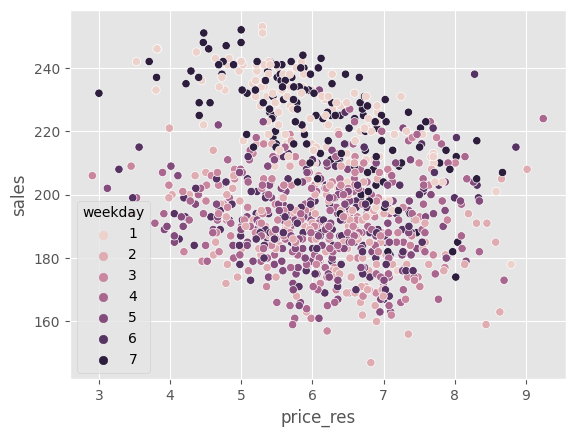

In [8]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

$M_t$는 treatment의 편향을 제거합니다. $M_y$는 어떨까요? $M_y$의 역할은 $Y$의 변동을 제거하는 것입니다. 따라서 저는 $M_y$를 denoising 모델이라 부릅니다. 직관적으로 $M_y$는 $X$로 설명되는 모든 변동이 제거된 결과를 만듭니다. 따라서 $\tilde{Y}$에서 인과 추정이 더 쉬워집니다. noise가 적기 때문에 쉽게 인과관계를 볼 수 있게 되는 것이지요.

In [9]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

앞의 그래프와 비교하면 매출의 잔차에서 변동은 이전보다 훨씬 작아진다는 사실을 확인할 수 있습니다.

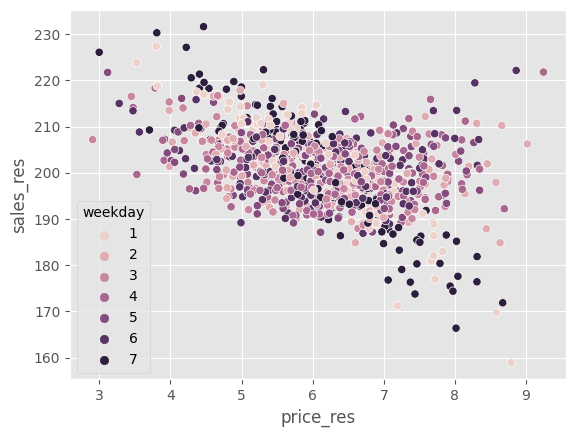

In [10]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

이제 가격과 판매 사이의 부정적인 관계를 쉽게 볼 수 있습니다.
 
최종적으로 인과 관계를 추정하기 위해 잔차에 대한 회귀 분석을 수행할 수 있습니다.

In [11]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.5586,0.443,506.469,0.000,223.689,225.428
price_res,-3.9228,0.071,-54.962,0.000,-4.063,-3.783


매출과 가격의 잔차 혹은 직교화를 사용할 때, 가격과 매출 사이의 음의 관계를 확신할 수 있습니다. 이는 상식과 일치합니다. 가격을 올리면 아이스크림 수요가 떨어질 것입니다.

하지만 가격과 판매 사이의 잔차가 아닌, 본래의 관계를 보면 편향 때문에 양의 관계를 발견하게 됩니다. 따라서 가격이 올라감에도 판매가 늘어나게 됩니다.

In [12]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


### CATE Estimation with Double-ML
 
지금까지 Double/Deviased ML의 Average Treatment Effect(ATE) 추정에 초점을 맞췄지만, treatment 효과의 이질성 또는 Conditional Average Treatment Effect(CATE) 추정에 사용할 수 있습니다. 기본적으로 인과 파라미터 $\tau$는 단위 공변량에 따라 변할 수 있다고 해봅시다.
 
$
Y_i - {M}_y(X_i)
= \tau(X_i) \cdot (T_i - {M}_t(X_i)) + \epsilon_i
$
 
모델을 추정하기 위해서 위와 같이 가격과 판매의 잔차화 버전을 사용하지만 이제 가격 잔차는 다른 공변량과 상호 작용합니다. 그러면 선형 CATE 모델을 훈련 시킬 수 있습니다.
 
$
\tilde{Y_i} = \alpha + \beta_1 \tilde{T_i} + \pmb{\beta}_2 \pmb{X_i} \tilde{T_i} + \epsilon_i
$
 
모델을 훈련하고 난 뒤에는 CATE 예측을 위해 무작위 테스트 세트를 사용합니다. 이 최종 모델이 선형이기 때문에 기계적으로 CATE를 계산할 수 있습니다.

$
\hat{\mu}(\partial Sales_i, X_i) = M(Price=1, X_i) - M(Price=0, X_i)
$

$M$은 우리의 최종 선형 모델입니다.

In [13]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

가격 민감도가 높은 단위와 가격 민감도가 낮은 단위를 구별하는 측면에서 이 모델이 얼마나 우수한지 확인하기 위해 누적탄성곡선을 활용합니다.

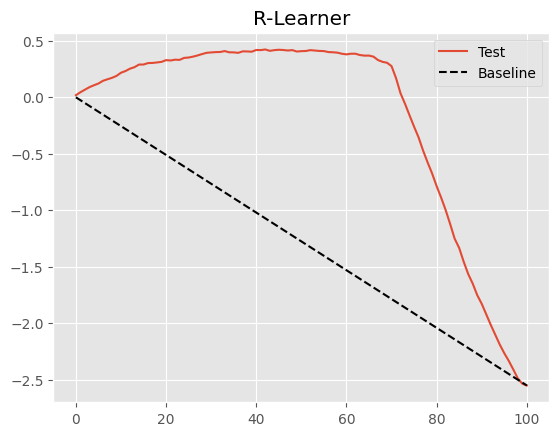

In [14]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

위의 곡선에서 보이듯이 최종 선형 모델을 사용한 Double/Debiased ML 방법은 이미 매우 우수합니다. 하지만 우리는 더 잘할 수 있습니다. 사실 이는 meta-learner와 같이 우리가 이해할 수 있는 매우 일반적인 방법입니다. Nie와 Wager는 Robinson의 업적을 기리고 잔차화를 강조하기 위해 이 방법을 R-Learner라고 불렀습니다.
 
Double/Debiased ML은 새로운 손실 함수를 정의함으로써 일반화시킬 수 있습니다. 다음 세션에서는 앞서 논의했던 target 변환/F-learner와 유사하게 처리하는 방법에 대해 알아보겠습니다.

## Non Parametric Double/Debiased ML
 
Double-ML의 장점은 인과관계 모델에서 성가신 파라미터를 학습하는 번거로움을 없앤다는 점입니다. 이를 통해 ATE든 CATE든 관심 있는 인과적 파라미터를 학습하는 데 집중할 수 있습니다. 그러나 위 방법은 ML 잔차화 후 최종 모형으로 여전히 선형 모형을 사용합니다. 이 예제에서는 가격이 매출에 선형적으로 영향을 미친다고 가정합니다. 작은 범위에서는 괜찮겠지만 미시경제학에 따르면 반드시 그렇지는 않습니다. 낮은 가격에는 1 단위 가격이 상승할 때 수요는 2 단위만큼 줄 수 있습니다. 반면 높은 가격에서는 1 단위 가격은 단지 1 단위 수요를 줄일 수 있습니다. 이는 선형적인 관계가 아닙니다.

미시경제 이론으로 treatment에 대한 함수를 추측할 수 있지만 이를 ML 모델에 위임할 수도 있습니다. 다시 말해 복잡한 함수를 모델이 학습하도록 합니다. 밝혀진 바와 같이 Double/Debiased ML 알고리즘을 몇 가지 바꾸면 가능합니다.
 
먼저 ML 모델과 교차 예측을 활용한 treatment 의 직교화로 시작합니다.

In [15]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

아직까지는 똑같아요. 지금부터 재미있어집니다. Double/Debiased-ML는 아래와 같습니다.

$
Y_i = \hat{M}_y(X_i) + \tau(X_i) \big(T_i - \hat{M}_t(X)\big) + \hat{\epsilon}_i
$
 
$\hat{M}_y$와 $\hat{M}_t$는 각각 feature로부터 output과 treatment를 예측하는 모델입니다. 식을 재배치 하여 오류 항을 분리합니다.

$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$

이는 **causal loss function**라 불립니다. 즉, 이 손실의 제곱을 최소화하여 예상 값인 CATE인 $\tau(X_i)$를 추정할 수 있습니다.
 
$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$
 
이 손실은 R-learner가 최소화 하는 것으로 **R-Loss*라고도 합니다. 이 손실 함수는 어떻게 최소화 할까요? 실제로 여러 가지 방법이 있지만 여기서는 가장 간단한 방법을 살펴보겠습니다. 먼저 식을 간단히 하기 위해 treatment와 result의 잔차로 고쳐쓰겠습니다.

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$
 
마지막으로 $\tilde{T}_i$를 $\tau(X_i)$와 분리하기 위해 수학적 파쿠르를 수행합니다.
 
$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2 
$$
 
위의 손실을 최고화 하는 것은 괄호 안의 값을 최소화 하는 것과 동일하며 이는 $\tilde{T}_i^2$ 만큼 가중치가 적용됩니다. 괄호를 최소화 하는 것은 $\frac{\tilde{Y}_i}{\tilde{T}_i}$를 예측하는 것과 같습니다. 이는 non-parametric causal loss를 얻기 위한 weight trick이라 불립니다. 앞서 살펴본 target transformation 아이디어와 유사한 방법입니다. 이는 실제로 추가적인 가중치 trick이 더해진 target transformation 입니다.

코드를 작성하기 전에 요약하자면, now that we have the nuisance models and residualised versions of treatment and outcome, we will

1. 가중치 $\tilde{T}_i^2$를 얻습니다.
2. target $\dfrac{\tilde{Y}_i}{\tilde{T}_i}$을 계산합니다.
3. 무엇이든 예측 방법을 사용해 (2)의 target을 예측합니다. (1)의 가중치를 곱해줍니다.
 
그리고 여기 코드가 있습니다. 보시다시피, 믿을 수 없을 정도로 간단합니다.

In [16]:
model_final = LGBMRegressor(max_depth=3)
 
# create the weights
w = train_pred["price_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

위의 ML 모델은 기성 예측 모델임에도 CATE를 추정합니다. 이것이 non-parametric Double-ML의 힘입니다. 이전에는 선형 회귀 분석을 CATE 추정의 최종 모델로 사용했습니다. 이제 일반적인 손실을 정의했으므로 최종 모형으로 임의의 예측 모형을 사용할 수 있습니다.
 
이제 테스트 세트를 사용해 이 non-parametric 버전을 이전에 사용했던 선형 버전과 비교해보겠습니다.
 
먼저 개별 치료 효과를 추정합니다.

In [17]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

다음으로, Double/Orthogonal-ML로 얻은 선형 버전과 non-parametric 버전의 누적탄성곡선을 나란히 표시합니다.

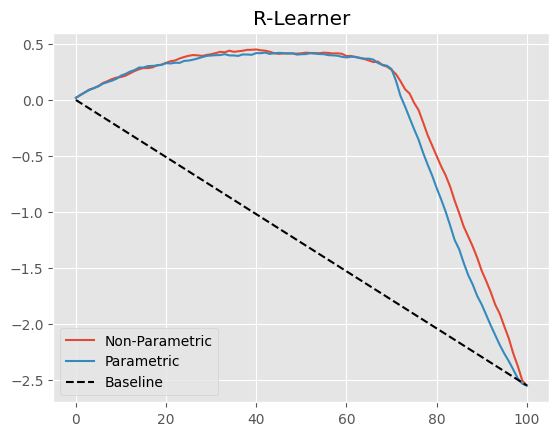

In [18]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

큰 향상은 없지만 중요한 결과 입니다. treatment 함수를 지정하지 않는 것만으로도 이미 큰 이점입니다.

### What is Non-Parametric About?
 
다음 단계로 넘어가기 전에 일반적인 오해를 강조하고 싶습니다. non-parametric Double-ML 모델로 CATE를 추정하면 비선형 treatment를 얻을 것으로 보입니다. 예를 들어, 할인 효과가 판매에 비선형적인 (제곱근 함수를 따르는) 아주 간단한 데이터 생성 프로세스 (DGP)를 가정해보죠.
 
$
Sales_i = 20 + 10*\sqrt{Discount_i} + e_i
$
 
treatment 효과는 판배 함수의 treatment에 대한 도함수로 주어집니다.

$
\dfrac{\partial Sales_i}{\partial Discount_i} = \dfrac{10}{2\sqrt{Discount_i}}
$
 
treatment 효과는 선형이 **아닙니다**. 실제로는 treatment가 증가할수록 약해집니다. 이는 이 DGP에 이치에 맞습니다. 처음에 조금 할인하면 매출이 많이 늘어납니다. 하지만 너무 많은 할인을 하더라도 수요가 무한하지는 않기 때문에 추가 할인은 매출에 점점 더 영향을 덜 미칠 것 입니다. 따라서, 할인은 사람들이 만족할 때까지만 유효합니다.

질문은 non-parametric ML이 treatment 효과의 포화를 포착하는지 입니다. 할인율이 더 높으면 treatment 효과가 더 낮을 것이라고 작은 할인 수준에서 추정할 수 있을까죠? 정답은... 어느 정도 가능합니다. 더 잘 이해하기 위해, 위의 DGP와 같은 데이터를 생성해 봅시다.

In [19]:
np.random.seed(321)
n=5000
discount = np.random.gamma(2,10, n).reshape(-1,1)
discount.sort(axis=0) # for better ploting
sales = np.random.normal(20+10*np.sqrt(discount), 1)

이 DGP를 그림으로 표시하면 이 변수들 사이의 제곱근 관계를 알 수 있습니다.

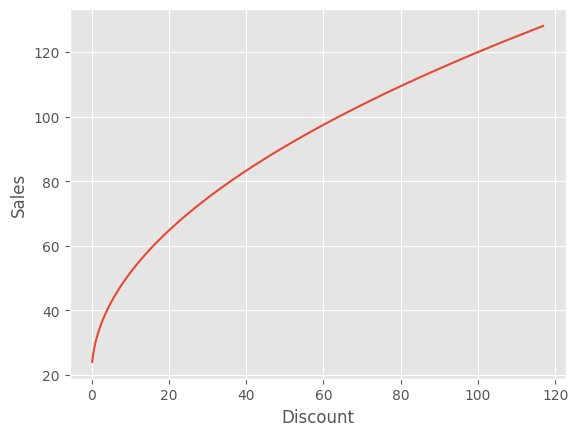

In [20]:
plt.plot(discount, 20 + 10*np.sqrt(discount))
plt.ylabel("Sales")
plt.xlabel("Discount");

이제 이 데이터를 non-parametric Double/Debise ML에 적용하겠습니다.

In [21]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# orthogonalising step
discount_res =  discount.ravel() - cross_val_predict(debias_m, np.ones(discount.shape), discount.ravel(), cv=5)
sales_res =  sales.ravel() - cross_val_predict(denoise_m, np.ones(sales.shape), sales.ravel(), cv=5)

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3)
w = discount_res ** 2 
y_star = sales_res / discount_res

non_param.fit(X=discount_res.reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel());

위 모델로 우리는 CATE를 얻을 수 있습니다. 여기서 문제는 CATE가 선형적이 아니라는 것입니다. treatment가 증가할수록 CATE는 감소해야 합니다. 우리가 대답하고자 하는 질문은 non-parametric 모델이 비선형성을 포착할 수 있는가 하는 것입니다.

이에 대해 제대로 답하기 위해, Double/Debiased ML이 데이터 생성 프로세스에 어떤 가정을 하는지 기억해봅시다. 이러한 가정은 이전에 제시한 방정식에서 볼 수 있습니다.

$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$
 
즉, 잔차화 된 output은 잔차화 된 treatment와 조건부 treatment 효과를 곱한 값과 같습니다. 따라서 **treatment는 결과에 선형적인 영향을 미칩니다**. 여기에는 비선형성이 없습니다. 위 모델은 treatment가 1에서 10 또는 100에서 110으로 증가시키면 결과가 고정된 양인 $\tau(X_i)$ 만큼 증가할 것이라 말합니다. 단순한 곱셈이죠.

그렇다면 non-parametric model은 treatment 효과의 비선형성을 포착할 수 없을까요? 다시 말하지만, 그렇진 않아요... 대신 Double/ML **비선형 CATE 에 대한 국소적인 선형 근사치를 찾습니다.** 즉, 해당 treatment 수준 또는 treatment 주변에서 output의 treatment에 대한 도함수를 찾습니다. 이는 treatment 지점에서 output 함수에 접하는 선의 기울기를 찾는 것과 같습니다.
 
![img](./data/img/debiased-ml/linear-aprox.png)
 
이 의미는.. 네. Non-Parametric Double-ML은 treatment가 커질 때 treatment 효과가 더 작아진다는 것을 알 수 있습니다. 하지만 비선형 treatment 효과가 아니라 국소적인 선형 treatment 효과를 찾습니다. 우리는 심지어 정답 비선형 인과 효과와 선형 근사치를 그래프로 표기할 수 있고, 실제로 이는 좋은 근사치입니다.

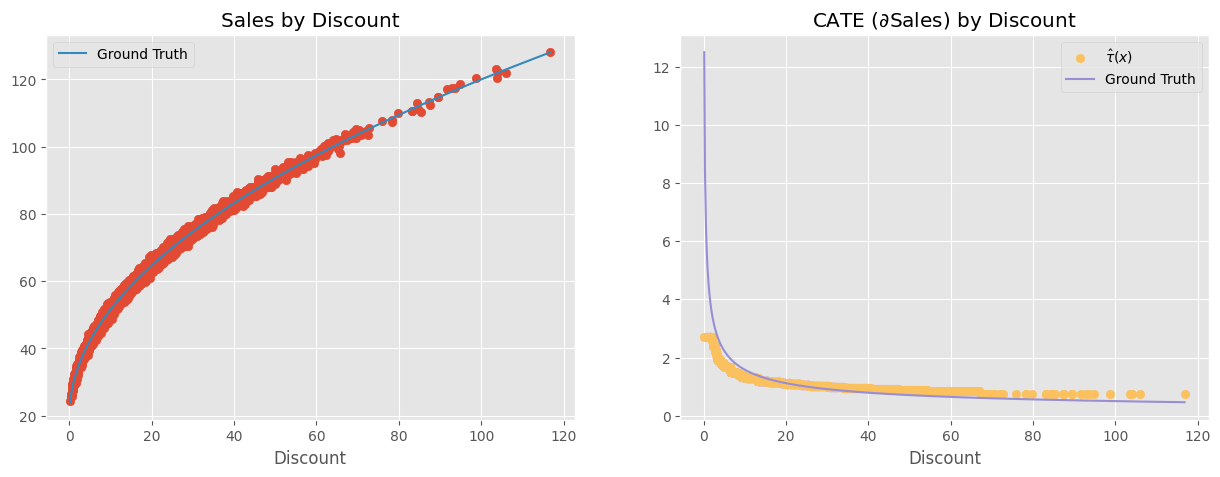

In [22]:
cate = non_param.predict(X=discount)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(discount, sales)
plt.plot(discount, 20 + 10*np.sqrt(discount), label="Ground Truth", c="C1")
plt.title("Sales by Discount")
plt.xlabel("Discount")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
plt.plot(discount, 5/np.sqrt(discount), label="Ground Truth", c="C2")
plt.title("CATE ($\partial$Sales) by Discount")
plt.xlabel("Discount")
plt.legend();

이것은 기술적인 것처럼 들릴 수 있지만, 매우 실용적인 결과를 가져옵니다. 예를 들어, 위의 예제에서 고객에 대한 treatment 효과가 2라고 가정해 보겠습니다. 즉, 할인을 1단위 늘리면 해당 고객에 대한 매출이 2단위로 늘어납니다. 여러분은 이렇게 생각할지도 모릅니다: "좋아요! 많이 할인해 드리겠습니다! 그럼 할인 1단위 당 2개씩 팔수 있습니다." 하지만, 이는 잘못된 결론입니다. 치료 효과는 해당 할인 수준에서만 2 입니다. 할인을 늘리면 바로 효과가 떨어질 것입니다. 예를 들어, 이 가상의 고객이 할인 혜택을 5 단위 밖에 받지 못했기 때문에 그녀의 treatment 효과가 매우 높다고 가정해 보겠습니다. 그 엄청난 treatment 효과를 보고 그 고객에게 20 만큼 할인해 주자고 말해보세요. 하지만 이렇게 하면 효과는 2에서 0.5가 됩니다. 그리고 treatment 효과가 2일 때 타당했던 20 할인은 treatment 효과가 0.5일 때 더 이상 이익이 되지 않을 수 있습니다.
 
비선형 treatment 효과를 새로운 treatment 수준으로 확장할 때는 주의를 기울여야 합니다. 그렇지 않으면 여러분은 결국 매우 수익성이 없는 결정을 내릴 수도 있습니다. 또 다른 표현 방법은 treatment 효과가 선형적이지 않을 때 non-parametric Double/Debiased-ML는 **반사실적 결과 예측에 어려움을 겪을 수 있습니다**. 낮은 treatment 수준에서 높은 treatment 수준으로 또는 그 반대로 treatment 효과(TE)를 선형적으로 추정하려고 시도합니다. 그리고 비선형성 때문에, 그 외삽법은 무효가 될 것입니다.

그것을 해결하기 위해, 최종적인 아이디어가 있습니다. 이 아이디어는 우리가 전에 본 것보다 훨씬 덜 과학적이라는 것을 명심하세요. 직교화 절차를 적용한 후 S-learner를 사용하는 것으로 요약되지만, 저는 앞서가고 있습니다. 다음 단계로 넘어가죠.

![img](./data/img/debiased-ml/non-sci.png)

## Non-Scientific Double/Debiased ML

우리가 시도할 마지막 아이디어는 정신의 근본적인 변화입니다. 우리는 더 이상 CATE에 대한 선형 근사치를 추정하려고 하지 않습니다. 대신, 우리는 반실제적인 예측을 할 것입니다.
 
![img](./data/img/debiased-ml/cf-pred.png)
 
CATE는 데이터 지점에서 결과 함수의 기울기입니다. 아주 적은 양으로 치료를 늘리면 결과가 얼마나 달라질 것으로 예상하느냐입니다. 좀더 기술적으로, 그것은 그 점에서 미분값 입니다. 반면, 반사실적 예측은 단일 데이터 지점에서 전체 결과 곡선을 재현하려는 시도입니다. 우리는 만약 그 치료가 현재 취하고 있는 것과 다른 수준이었다면 어떤 결과가 나올지 예측할 것이고, 따라서 그 결과는 반사실적일 것입니다.

그렇게 하면 한 단위에 대해 다른 치료법을 시뮬레이션하고 다른 치료 수준 하에서 어떤 반응을 보일지 예측할 수 있을 것입니다. 이것은 매우 위험한 작업입니다. 왜냐하면 우리는 하나의 점에서 전체 곡선을 추정하기 때문입니다. 또한, 비록 제가 이 기술을 실제로 많이 사용해 보았지만, 저는 그것이 어떻게, 왜 작동하는지 보여주는 어떠한 과학 기사도 발견하지 못했습니다. 그래서 비과학적인 Double-ML이라고 부르죠. 간단히 말해서, 주의하세요!

이것이 어떻게 진행될지 알려드립니다. 먼저, 기존의 Double/Debiased-ML 공식부터 시작하겠습니다. 여기서 치료와 결과의 잔차 버전을 확인할 수 있습니다.
 
$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$
 
이제 트리트먼트 효과 기능 안으로 트리트먼트를 이동하겠습니다. 이렇게 하면 처리 효과가 비선형적일 수 있습니다. 즉, 처리 자체와 함께 변경될 수 있습니다.

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$
 
이 치료 함수가 어떨지 모르기 때문에 이는 위험한 작업입니다. 우리가 아는 한, 그것은 이상한 비선형 함수일 수 있습니다. 하지만 다행히도, 우리는 머신 러닝으로 이상한 함수를 추정하는 방법을 알고 있습니다. 그래서 그렇게 할 겁니다. 간단히 말해서, 우리는 잔차 결과 $\tilde{T}$를 예측하기 위해 ML 모델을 맞출 것입니다. 잔차화 처리 결과 $\tilde{Y}$ 를 $\tilde{T}$ 와 feature $X$ 로 얻습니다. 잔차화는 이 최종 ML이 치료 효과와 공변량 $X$가 치료 효과에 어떻게 영향을 미치는지 학습에만 집중할 수 있도록 편향과 노이즈를 제거하는 데 중요합니다.
 
Then, once we have this model, we will make 2 step counterfactual predictions. First we will have to make a prediction for the treatment in order to get $\tilde{T}$, then, we will feed that prediction, along with the features, in our final model $\hat{\tau}(X_i, \tilde{T}_i)$.
그런 다음, 이 모델이 있으면 2단계 반실제 예측을 할 것입니다. 먼저 $\tilde{T}$ 수준에서 treatment 예측값을 얻습니다. 그런 다음 예측값과 feature로 예측을 수행합니다. $\hat{\tau}(X_i, \tilde{T}_i)$ 

우리는 $\tilde{T}$를 만들어야 하기 때문에 우리는 먼저 우리 자신의 버전의 'cross_prediction' 함수를 구현해야 합니다. 이 함수는 교차 예측뿐만 아니라 이러한 예측을 수행하는 데 사용된 모형도 반환합니다.

In [23]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)
    m = model(**model_params)
    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models


이제 모델을 제공하는 자체 교차 예측 기능이 있으므로 직교화 단계를 진행할 수 있습니다.

In [24]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

After the orthogonalisation, we will throw $\tilde{T}$ along with $X$ to a ML model that tries to precit $\tilde{Y}$. I'm using a LGBM model here, but you can pick any ML model. One cool thing about LGBM is that I can set monotonic constraints to it. Knowing what we know about prices, sales should decrease as price increases. We can take that into account and constrain our LGBM model **to not increase** it's predictions as prices increase. 
직교화 후, 우리는 $\tilde{T}$와 $X$를 ML 모델에 던져 $\tilde{Y}$를 예측합니다. 여기서 LGBM 모델을 사용하고 있지만 ML 모델은 아무거나 선택 가능합니다. LGBM의 한 가지 멋진 점은 단조로운 제약 조건을 설정할 수 있다는 것입니다. 우리가 가격에 대해 알고 있는 것을 알고 있기 때문에, 가격이 상승함에 따라 매출이 감소해야 합니다. 우리는 그것을 고려하여 가격이 상승함에 따라 LGBM 모델이 **증가하지 않도록 제한**합니다.

In [25]:
# -1 on price saying that the predictions should not increase as price increases
monotone_constraints = [-1 if col == T else 0 for col in X+[T]]
 
model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

이제 상황이 좀 이상해지는 부분입니다. 생각해보면, 이 최종 ML 모델은 다음과 같은 $\tau$ 처리 함수를 추정합니다.

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$
 
하지만 이 기능에서 치료 효과를 추출할 수 있는 명확한 방법은 없습니다. 그래서, 치료 효과를 추출하는 대신에, 이전 이미지에서 보여드린 것처럼, 우리는 반사실적인 예측을 입력할 것입니다. 각 유닛에 대해 서로 다른 가격 수준을 시뮬레이션하고 Double-ML 모델을 사용하여 이러한 다른 가격 수준에서 어떤 판매가 발생할지 예측할 것입니다.

이를 위해 1) 모든 시뮬레이션 가격이 포함된 가격표와 테스트 세트를 교차 결합합니다. 최종 결과는 다음과 같습니다.

In [26]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price
0,0,25.8,1,0.3,7,230,3.000
1,0,25.8,1,0.3,7,230,3.875
2,0,25.8,1,0.3,7,230,4.750
3,0,25.8,1,0.3,7,230,5.625
4,0,25.8,1,0.3,7,230,6.500
5,0,25.8,1,0.3,7,230,7.375
6,0,25.8,1,0.3,7,230,8.250
7,0,25.8,1,0.3,7,230,9.125
8,0,25.8,1,0.3,7,230,10.000


인덱스 1에는 날짜만 표시되므로 단일 단위만 표시됩니다. 그날(단위) 실제 또는 사실상의 가격 또는 처리는 7이었습니다. 하지만 우리는 3번부터 10번까지 다양한 반실제 치료법을 시뮬레이션했습니다. 이제, 우리는 이러한 모든 반실제 가격을 우리의 인과 모델에 반영할 것입니다. 그러면 시뮬레이션된 가격을 기반으로 반실제 판매 예측을 할 수 있습니다.

우리 모델은 다음과 같은 형식을 가지고 있습니다.
 
$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$
 
반실제 예측을 하기 전에 $\tilde{T}_i$를 얻어야 합니다. 즉 가격 잔차입니다. 먼저 이러한 잔차를 얻고 모든 치료 모델을 예측한 다음(교육 단계에서 5 fold 교차 예측을 사용했다는 것을 기억하십시오), 다섯 모델의 예측을 단일 예측으로 평균한 다음 마지막으로 이를 사용하여 이전에 생성한 반실제 가격을 예측 가격에서 뺍니다. 모델의 앙상블입니다.

In [27]:
def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,24.302849
1,0,25.8,1,0.3,7,230,3.875,20.862833
2,0,25.8,1,0.3,7,230,4.750,14.401401
3,0,25.8,1,0.3,7,230,5.625,6.274595
4,0,25.8,1,0.3,7,230,6.500,-1.624625
5,0,25.8,1,0.3,7,230,7.375,-12.539291
6,0,25.8,1,0.3,7,230,8.250,-23.332933
7,0,25.8,1,0.3,7,230,9.125,-25.319174
8,0,25.8,1,0.3,7,230,10.000,-25.319174


보시다시피, 이제 모든 모의 가격에 대한 판매 예측을 볼 수 있습니다. 가격이 낮을수록 판매량은 높아집니다. 한 가지 흥미로운 것은 이러한 예측들이 그들의 수준에서 빗나간다는 것입니다. 예를 들어, 그들은 약 24에서 약 -24로 이동합니다. 이는 모형이 잔차화된 결과를 예측하고 있기 때문이며, 이는 대략 평균 0입니다. 판매 곡선의 기울기, 즉 가격 처리 효과만 얻으면 됩니다. 또한 예측 수준을 고정하려면 노이즈 제거 모델 $M_y$의 예측을 추가하면 됩니다.

In [28]:
y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = (y_hat_test + 
                          model_final.predict(X=pred_test[X].assign(**{T: t_res_test})))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,255.459625
1,0,25.8,1,0.3,7,230,3.875,252.019609
2,0,25.8,1,0.3,7,230,4.750,245.558177
3,0,25.8,1,0.3,7,230,5.625,237.431371
4,0,25.8,1,0.3,7,230,6.500,229.532151
5,0,25.8,1,0.3,7,230,7.375,218.617485
6,0,25.8,1,0.3,7,230,8.250,207.823843
7,0,25.8,1,0.3,7,230,9.125,205.837602
8,0,25.8,1,0.3,7,230,10.000,205.837602


단위 수준 판매 곡선을 그릴 수도 있습니다. 10개의 유닛을 표본으로 추출하여 서로 다른 가격에서 어떻게 작동하는지 확인해 보겠습니다.

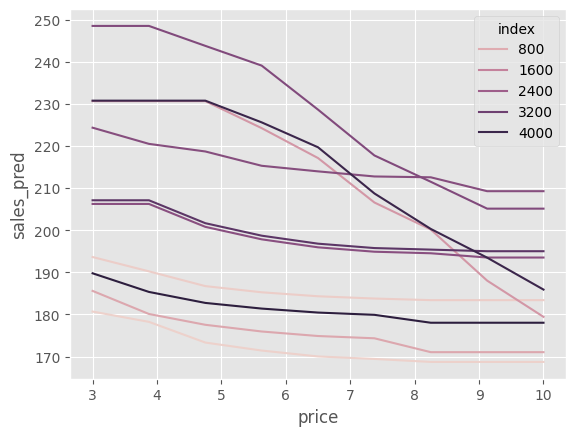

In [29]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

일부 유닛이 가격 인상에 매우 민감하다는 것은 흥미로운 사실입니다. 어떤 경우에는 3개에서 10개로 가격을 올리면서 매출이 250개에서 거의 200개로 줄어들 것으로 예상합니다. 반면에, 일부 유닛들은 가격에 대해 매우 비탄력적입니다. 우리가 가격을 3에서 10으로 인상함에 따라, 우리는 판매가 약 195에서 약 185로 증가할 것으로 예상합니다.
 
가격 민감도에서 이러한 차이를 발견하기 어렵기 때문에 제가 좋아하는 것은 모든 곡선이 같은 지점(여기서 평균 판매량)에서 시작되도록 하는 것입니다. 이렇게 하면 가격을 올리면서 판매량이 급감하는 유닛도 있고 그렇지 않은 유닛도 있다는 것을 쉽게 알 수 있을 것입니다.

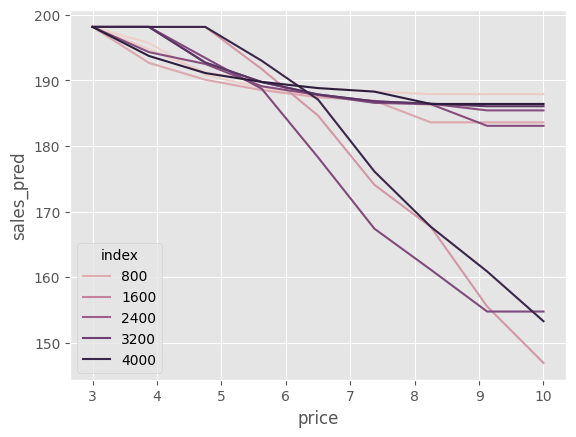

In [30]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

### More Econometrics May be Needed!
 
![img](./data/img/debiased-ml/more-metrics.png)
 
비과학적인 Double-ML에 대한 이 섹션을 주의의 한마디로 끝내고 싶습니다. 저는 이 접근법을 괜히 비과학적이라고 하지 않았습니다. 비선형 반사실적 예측을 얻는 것은 일종의 해킹입니다. 그리고 그것이 해킹이기 때문에, 저는 그것의 잠재적인 단점에 대해 이야기할 가치가 있다고 생각합니다.
 
무엇보다도, 그것은 인과적 추론에 순진하게 적용될 때 모든 ML 기법이 가지고 있는 것과 동일한 문제를 가지고 있습니다: 편향. 최종 모델은 정규화된 ML 모델이기 때문에, 이 정규화는 인과 추정치를 0으로 편향시킬 수 있습니다.
 
두 번째 문제는 당신이 선택한 ML 알고리즘과 관련이 있습니다. 여기서, 우리는 boosted tree를 선택합니다. 나무는 매끄러운 예측을 잘 하지 못합니다. 결과적으로 예측 곡선에서 불연속성을 가질 수 있습니다. 위의 그림에서 볼 수 있습니다. 단계적 동작입니다. 또한, 나무는 추정을 잘 하지 못하기 때문에 이 모델은 이전에 보지 못한 가격에 대한 이상한 예측을 산출할 수 있습니다.

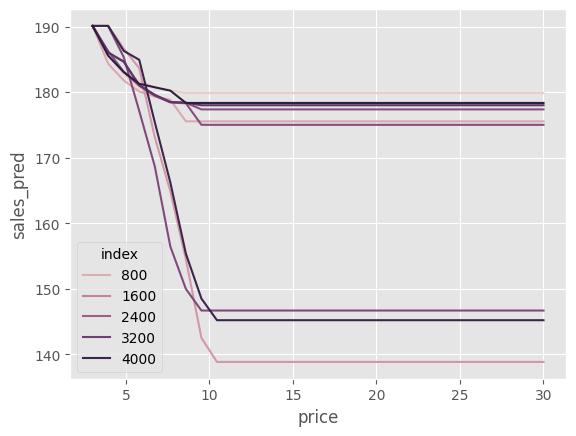

In [31]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 30, 30))), on="jk")
             .drop(columns=["jk"]))

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

이 모든 것은 이 접근 방식이 최종 ML 모델에 크게 의존한다는 것을 의미합니다. 너무 정규화하면 인과 추정치를 0으로 치우치게 됩니다. 이 또는 해당 ML 알고리즘을 사용하면 최종 반실제 예측에 대한 모든 제한이 적용됩니다. 그럼에도 불구하고, 만약 여러분이 이 접근법이 시도해 볼 가치가 있다고 생각한다면, 꼭 시도해 보세요! 제가 여기서 요약한 단점들을 잊지 마세요.

## Key Ideas
 
이중/편향/직교 ML은 관심의 인과적 매개 변수에 주의를 집중할 수 있는 성가신 매개 변수 추정을 위임하는 방법입니다. 먼저 2단계 직교화 절차를 사용합니다.
 
1. 공변량 X에서 처리를 예측하고 out of fold 잔차 $\tilde{t} = t - M_t(X)$를 얻기위해 모델 $M_t(X)$를 훈련시킵니다. 잔차 $\tilde{t}$는 특징과 직교하기 때문에 우리는 이것을 편향 제거 모델이라고 불렀습니다.
   
2. 공병량 X로부터 out of fold 잔차 $\tilde{y} = y - M_y(X)$ 를 계산하기 위해 $M_y(X)$를 훈련시킵니다. 잔차 $\tilde{y}$는 feature에 의한 분포가 제거된 버전으로 볼 수 있기 때문에 이를 노이즈 제거 모델이라고 불렀습니다.
 
이러한 잔차가 있으면 측정되지 않은 교란이 없으면 ATE에 대한 선형 근사치를 위해 $\tilde{t}$에서 $\tilde{y}$를 회귀시킬 수 있습니다. 또한 $\tilde{t}$를 공변량과 상호 작용하여 CATE를 추정하거나 가중치 트릭을 사용하여 최종 CATE 모델로 일반 ML 모델을 허용할 수 있습니다.

 
![img](./data/img/debiased-ml/diagram.png) 
 
마지막으로, 저는 직교화 단계가 인과 학습을 용이하게 하는 일반적인 도구라고 주장했습니다. 그러한 정신으로, 우리는 치료와 결과 잔차를 S-learner 스타일 ML 알고리즘에 공급하려고 노력했습니다. 이를 통해, 우리는 시뮬레이션된 치료법으로부터 반실제적인 예측을 얻을 수 있었습니다. 실제로 직교 ML은 많은 인과 추론 응용 프로그램에서 사전 처리 단계 역할을 합니다.

## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
To write this chapter, I've relied on Chernozhukov et al (2016), *Double/Debiased Machine Learning for Treatment and Causal Parameters*, D. Foster and V. Syrgkanis (2019) *Orthogonal Statistical Learning* and on the *econml* library documentation page. Orthogonal ML has gotten a lot of attention lately, so there are many other references on the subject. To name a few, Nie and Wager (Draft, 2020) have a nice discussion on the R-loss, Athey et al (2019) talk about it in the context of causal decision trees and there are many subsequent papers by Chernozhukov, which develop the subject further. 
 
I also stole an image from [Pedro Sant'Anna's slides](https://pedrohcgs.github.io/files/Callaway_SantAnna_2020_slides.pdf).

 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).